# 라이브러리

In [182]:
# !pip install scikit-learn
# !pip install koreanize_matplotlib
# !pip install nibabel

In [185]:
# 경로 처리
import os
from pathlib import Path
import glob

# 일반
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import koreanize_matplotlib
import numpy as np
import random
import tqdm as tqdm
import seaborn as sns

# 이미지 처리
import cv2
from PIL import Image

# 모델링
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import BatchNormalization
from keras.models import Model
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import h5py
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# 데이터 경로

In [132]:
# !unzip 'MRI Hippocampus.zip'

In [133]:
# root directory
root_dir = Path('Train/Dataset')

# main path
non_demented = Path(f'{root_dir}/Non_Demented')
very_mild_demented = Path(f'{root_dir}/Very_Mild_Demented')
mild_demented = Path(f'{root_dir}/Mild_Demented')
moderate_demented = Path(f'{root_dir}/Moderate_Demented')

# images
non_demented_img = list(non_demented.glob(r'**/*.jpg'))
very_mild_demented_img = list(very_mild_demented.glob(r'**/*.jpg'))
mild_demented_img = list(mild_demented.glob(r'**/*.jpg'))
moderate_demented_img = list(moderate_demented.glob(r'**/*.jpg'))

In [134]:
# series 형태로
non_demented_series = pd.Series(non_demented_img, name='Non_demented').astype(str)
very_mild_demented_series = pd.Series(very_mild_demented_img, name='Very_mild_demented').astype(str)
mild_demented_series = pd.Series(mild_demented_img, name='Mild_demented').astype(str)
moderate_demented_series = pd.Series(moderate_demented_img, name='Moderate_demented').astype(str)

# 정렬
non_demented_series = non_demented_series.sort_values().reset_index(drop=True)
very_mild_demented_series = very_mild_demented_series.sort_values().reset_index(drop=True)
mild_demented_series = mild_demented_series.sort_values().reset_index(drop=True)
moderate_demented_series = moderate_demented_series.sort_values().reset_index(drop=True)

# 확인
len(non_demented_series), len(very_mild_demented_series), len(mild_demented_series), len(moderate_demented_series)

(3200, 2240, 896, 64)

# 이미지 처리

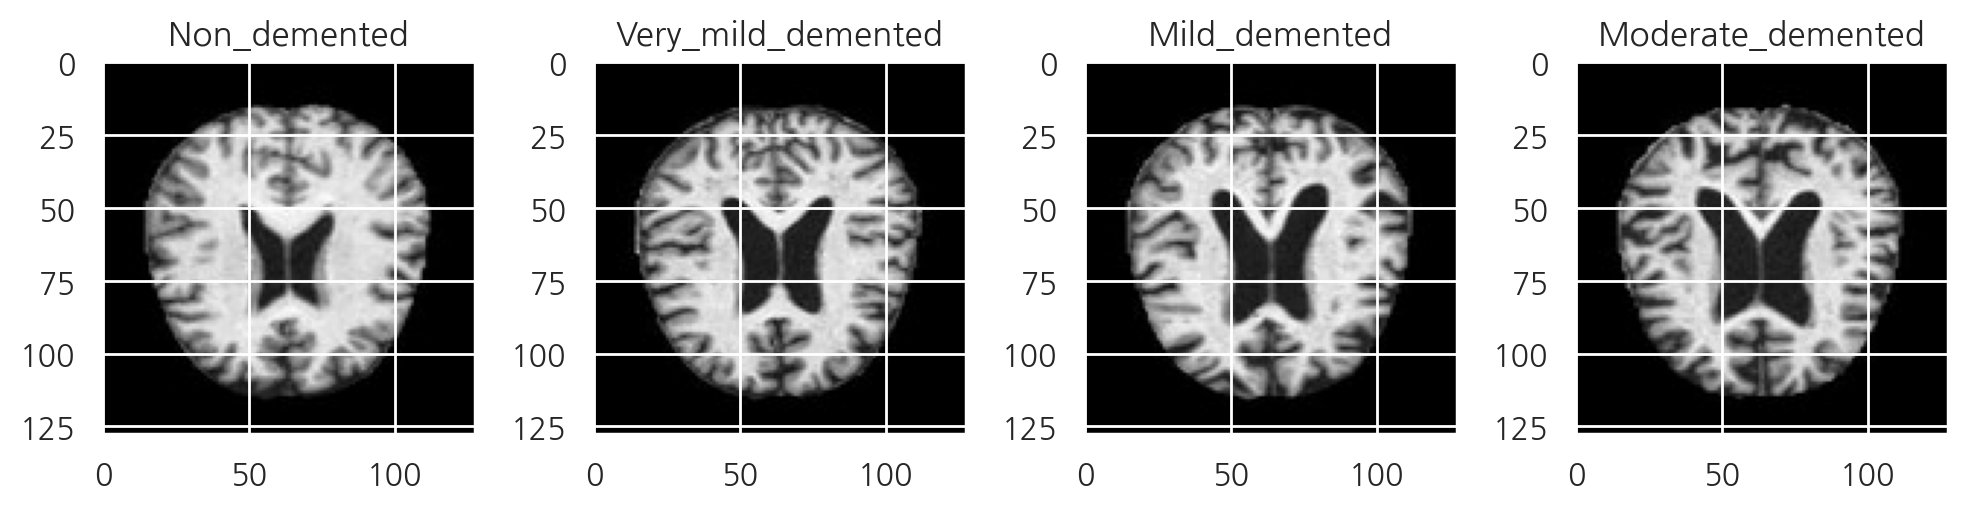

In [135]:
# 이미지 불러오기
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))

example_non = cv2.cvtColor(cv2.imread(non_demented_series[0]), cv2.COLOR_BGR2RGB)
example_very_mild = cv2.cvtColor(cv2.imread(very_mild_demented_series[0]), cv2.COLOR_BGR2RGB)
example_mild = cv2.cvtColor(cv2.imread(mild_demented_series[0]), cv2.COLOR_BGR2RGB)
example_moderate = cv2.cvtColor(cv2.imread(moderate_demented_series[0]), cv2.COLOR_BGR2RGB)

ax[0].set_title("Non_demented")
ax[0].imshow(example_non)

ax[1].set_title("Very_mild_demented")
ax[1].imshow(example_very_mild)

ax[2].set_title("Mild_demented")
ax[2].imshow(example_mild)

ax[3].set_title("Moderate_demented")
ax[3].imshow(example_moderate)

plt.tight_layout()

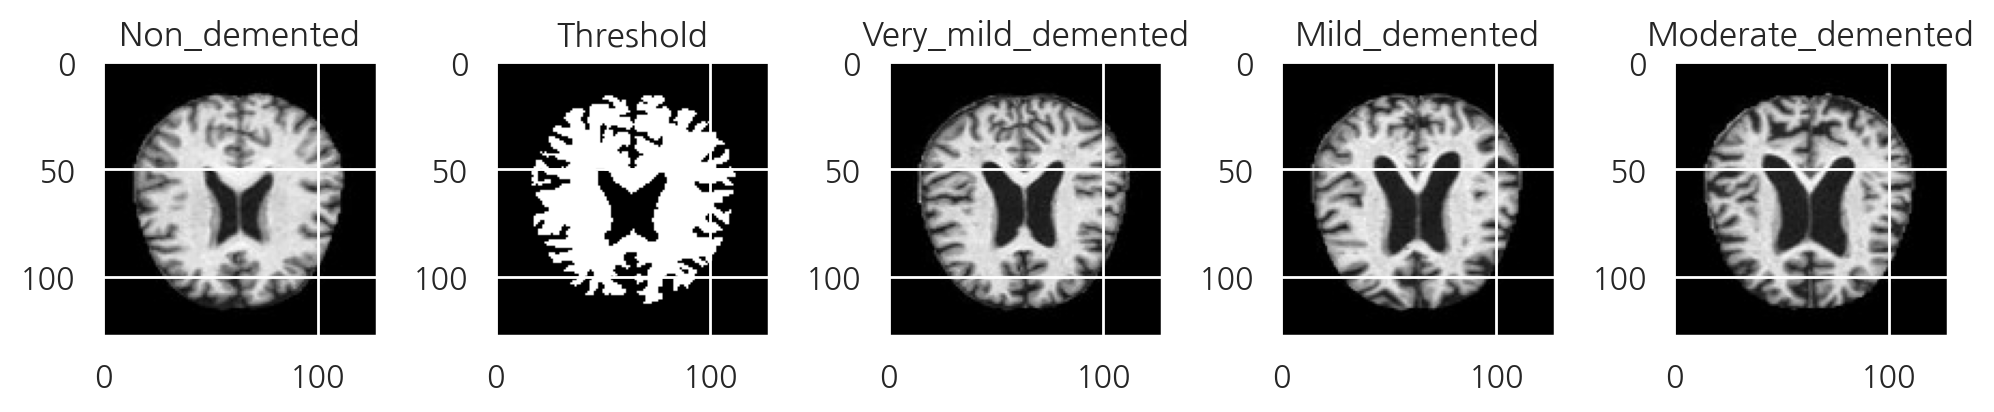

In [136]:
# threshold 조정
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))

example_non = cv2.cvtColor(cv2.imread(non_demented_series[0]), cv2.COLOR_BGR2RGB)
example_very_mild = cv2.cvtColor(cv2.imread(very_mild_demented_series[0]), cv2.COLOR_BGR2RGB)
example_mild = cv2.cvtColor(cv2.imread(mild_demented_series[0]), cv2.COLOR_BGR2RGB)
example_moderate = cv2.cvtColor(cv2.imread(moderate_demented_series[0]), cv2.COLOR_BGR2RGB)

_, threshold_img = cv2.threshold(example_non, 135, 255, cv2.THRESH_BINARY)

ax[0].set_title("Non_demented")
ax[0].imshow(example_non)

ax[1].set_title("Threshold")
ax[1].imshow(threshold_img)

ax[2].set_title("Very_mild_demented")
ax[2].imshow(example_very_mild)

ax[3].set_title("Mild_demented")
ax[3].imshow(example_mild)

ax[4].set_title("Moderate_demented")
ax[4].imshow(example_moderate)

plt.tight_layout()

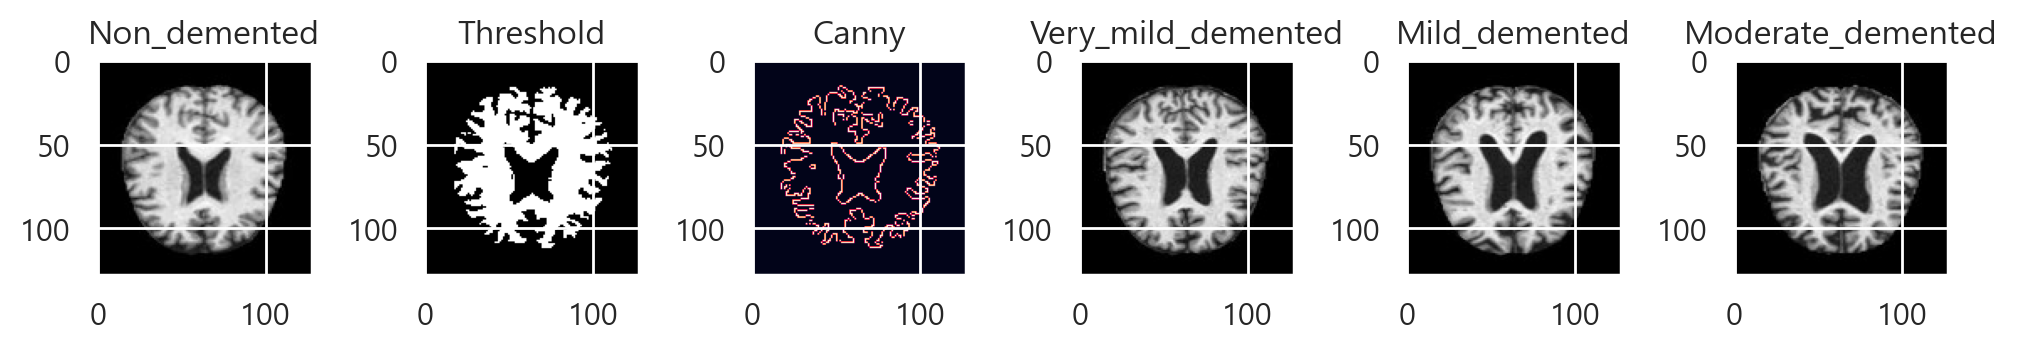

In [198]:
# canny 로 경계선 따기
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(10, 10))

example_non = cv2.cvtColor(cv2.imread(non_demented_series[0]), cv2.COLOR_BGR2RGB)
example_very_mild = cv2.cvtColor(cv2.imread(very_mild_demented_series[0]), cv2.COLOR_BGR2RGB)
example_mild = cv2.cvtColor(cv2.imread(mild_demented_series[0]), cv2.COLOR_BGR2RGB)
example_moderate = cv2.cvtColor(cv2.imread(moderate_demented_series[0]), cv2.COLOR_BGR2RGB)

_, threshold_img = cv2.threshold(example_non, 145, 255, cv2.THRESH_BINARY)
canny_img = cv2.Canny(threshold_img, 10, 135)

ax[0].set_title("Non_demented")
ax[0].imshow(example_non)

ax[1].set_title("Threshold")
ax[1].imshow(threshold_img)

ax[2].set_title("Canny")
ax[2].imshow(canny_img)

ax[3].set_title("Very_mild_demented")
ax[3].imshow(example_very_mild)

ax[4].set_title("Mild_demented")
ax[4].imshow(example_mild)

ax[5].set_title("Moderate_demented")
ax[5].imshow(example_moderate)

plt.tight_layout()

In [148]:
# 3 개의 class 별로 threshold -> canny 과정을 거쳐서 저장
# non_demented
non = []
non_label = []

for _ in non_demented_series:
    img = cv2.cvtColor(cv2.imread(_), cv2.COLOR_BGR2GRAY)
    _, threshold_img = cv2.threshold(img,145,255, cv2.THRESH_BINARY)
    canny_img = cv2.Canny(threshold_img,10,135)
    
    non_label.append('non')
    non.append(canny_img)    

In [149]:
# mild_demented
mild = []
mild_label = []

for _ in very_mild_demented_series:
    img = cv2.cvtColor(cv2.imread(_), cv2.COLOR_BGR2GRAY)
    _, threshold_img = cv2.threshold(img,145,255, cv2.THRESH_BINARY)
    canny_img = cv2.Canny(threshold_img,10,135)
    
    mild_label.append('mild')
    mild.append(canny_img)

In [150]:
# moderate_demented
moderate = []
moderate_label = []

for _ in pd.concat([mild_demented_series, moderate_demented_series], axis=0):
    img = cv2.cvtColor(cv2.imread(_), cv2.COLOR_BGR2GRAY)
    _, threshold_img = cv2.threshold(img,145,255, cv2.THRESH_BINARY)
    canny_img = cv2.Canny(threshold_img,10,135)
    
    moderate_label.append('moderate')
    moderate.append(canny_img)

In [151]:
# 확인
len(moderate), len(moderate_label), moderate[0].shape, moderate_label[0]

(960, 960, (128, 128), 'moderate')

In [152]:
# img를 np.array형태로 변환해서 저장
X = [np.array(img) for img in non + mild + moderate]

# array의 값을 0~1로 정규화
X = np.array(X)/255.

In [153]:
# 확인
X.shape

(6400, 128, 128)

In [154]:
y = []

# label 의 group 이름을 숫자로 인코딩 -> y에 담아주기
for label_mapping in non_label + mild_label + moderate_label:
    if label_mapping=='non': 
        y.append(0)
    elif label_mapping=='mild': 
        y.append(1)
    elif label_mapping=='moderate' : 
        y.append(2)
    
y = to_categorical(y)

In [155]:
# 확인
y.shape

(6400, 3)

In [156]:
# 모델에 넣을 수 있는 형태로 변환
X = X.reshape(6400, 128, 128, 1)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [157]:
# 확인
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5120, 128, 128, 1), (1280, 128, 128, 1), (5120, 3), (1280, 3))

# 모델링

## 모델 1

In [171]:
# CNN 모델 생성
cnn=Sequential()

#initially 64 convolution nodes
cnn.add(Conv2D(64,(3,3),padding="same",activation='relu',input_shape=X_train.shape[1:]))
#add a Max Pooling layer
cnn.add(MaxPooling2D())

#another 32 convolution nodes
cnn.add(Conv2D(32,(3,3),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())

#Add 32 convolutions
cnn.add(Conv2D(32,(2,2),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())

#Flatten before adding fully connected layer
cnn.add(Flatten())

#Add a hidden layer with 100 nodes
cnn.add(Dense(100,activation='relu'))

#Add another hidden layer with 50 nodes
cnn.add(Dense(50,activation='relu'))

# Add final ouptput layer : 클래스의 개수대로 만들어줌 (다중분류 softmax)
cnn.add(Dense(3, activation='softmax'))

In [172]:
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 32)      

In [173]:
# compile
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [174]:
# 모델 훈련
history = cnn.fit(X_train, y_train, 
                  validation_split=0.2,
                  shuffle=True,
                  epochs=20,
                  )

Epoch 1/20
128/128 [==============================] - 37s 283ms/step - loss: 0.9636 - accuracy: 0.5100 - val_loss: 0.9209 - val_accuracy: 0.5527
Epoch 2/20
128/128 [==============================] - 37s 287ms/step - loss: 0.8230 - accuracy: 0.5952 - val_loss: 0.7801 - val_accuracy: 0.6436
Epoch 3/20
128/128 [==============================] - 34s 266ms/step - loss: 0.6385 - accuracy: 0.7261 - val_loss: 0.7017 - val_accuracy: 0.6797
Epoch 4/20
128/128 [==============================] - 35s 272ms/step - loss: 0.4161 - accuracy: 0.8328 - val_loss: 0.5522 - val_accuracy: 0.7676
Epoch 5/20
128/128 [==============================] - 35s 276ms/step - loss: 0.2001 - accuracy: 0.9229 - val_loss: 0.6393 - val_accuracy: 0.7920
Epoch 6/20
128/128 [==============================] - 35s 276ms/step - loss: 0.1267 - accuracy: 0.9526 - val_loss: 0.5582 - val_accuracy: 0.8184
Epoch 7/20
128/128 [==============================] - 34s 267ms/step - loss: 0.0385 - accuracy: 0.9883 - val_loss: 0.5876 - val_ac

In [175]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.963619,0.510010,0.920882,0.552734
1,0.823018,0.595215,0.780063,0.643555
2,0.638491,0.726074,0.701665,0.679688
3,0.416125,0.832764,0.552241,0.767578
4,0.200051,0.922852,0.639310,0.791992
5,0.126724,0.952637,0.558178,0.818359
6,0.038503,0.988281,0.587599,0.838867
7,0.023524,0.993408,0.786987,0.826172
8,0.037766,0.988037,0.769998,0.808594
9,0.014472,0.995605,0.723060,0.834961


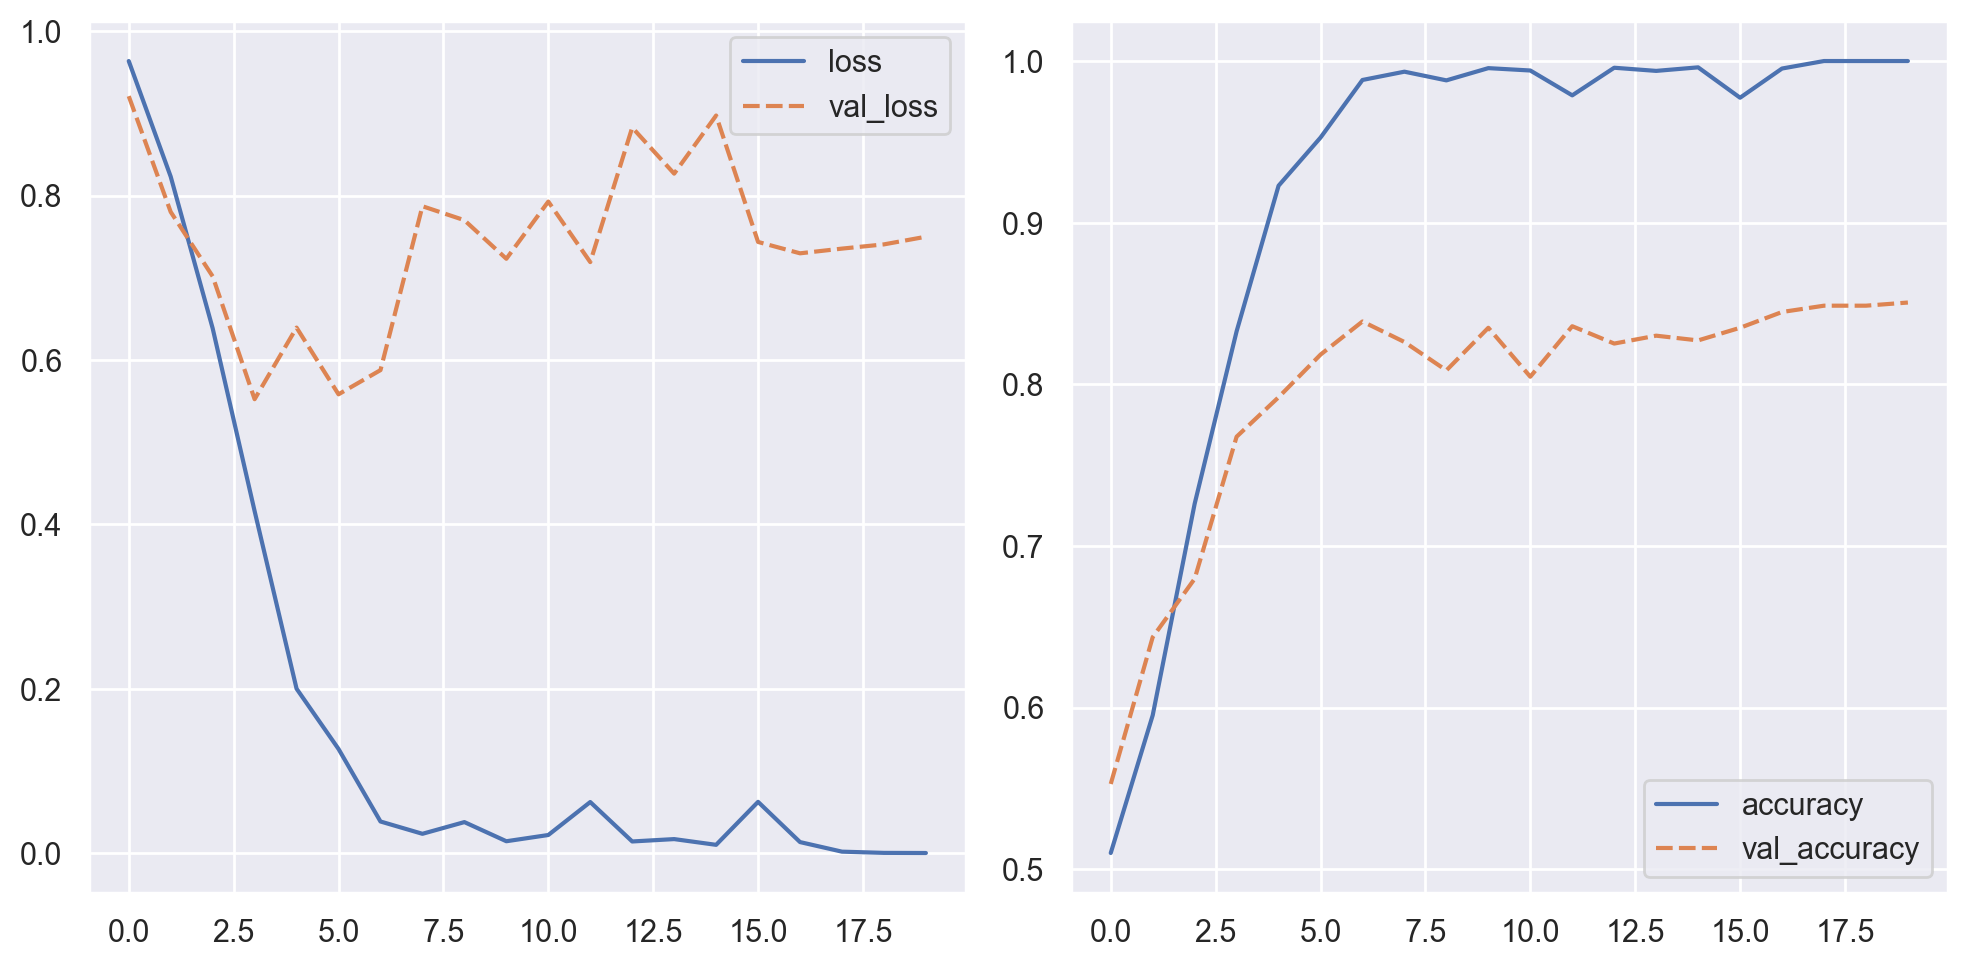

In [210]:
sns.set_theme()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=pd.DataFrame(history.history)[['loss', 'val_loss']], ax=ax[0])
sns.lineplot(data=pd.DataFrame(history.history)[['accuracy', 'val_accuracy']], ax=ax[1])

plt.tight_layout()

In [200]:
def result_summary(model, X_test, y_test):
    """
    model, X_test, y_test를 입력하면 confusion matrix, classification report를 보여주고
    y_pred_label을 리턴하는 함수
    """
    # X_test에 대한 정답값 예측
    y_pred = model.predict(X_test, verbose=0);
    
    # argmax로 클래스 중 정답값 선택
    y_test_label = [np.argmax(y) for y in y_test]
    y_pred_label = [np.argmax(y) for y in y_pred]

    # Classification Report
    clr = classification_report(y_test_label, y_pred_label)
    print("Classification Report\n----------------------\n", clr)

    # Confusion Matrix
    cm = confusion_matrix(y_test_label, y_pred_label)
    print("\n\nConfusion Matrix\n----------------------")
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual");

Classification Report
----------------------
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       640
           1       0.82      0.82      0.82       448
           2       0.86      0.80      0.83       192

    accuracy                           0.86      1280
   macro avg       0.85      0.84      0.85      1280
weighted avg       0.86      0.86      0.86      1280



Confusion Matrix
----------------------


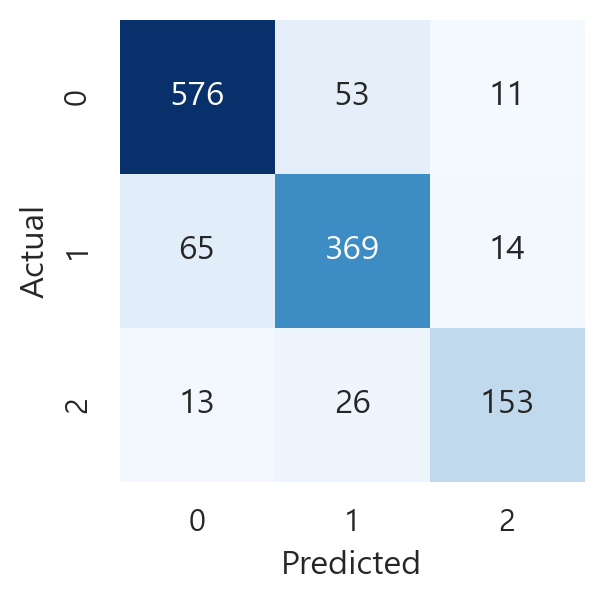

In [201]:
result_summary(cnn, X_test, y_test)

In [222]:
# plt.rcParams['font.family'] = 'Malgun Gothic'

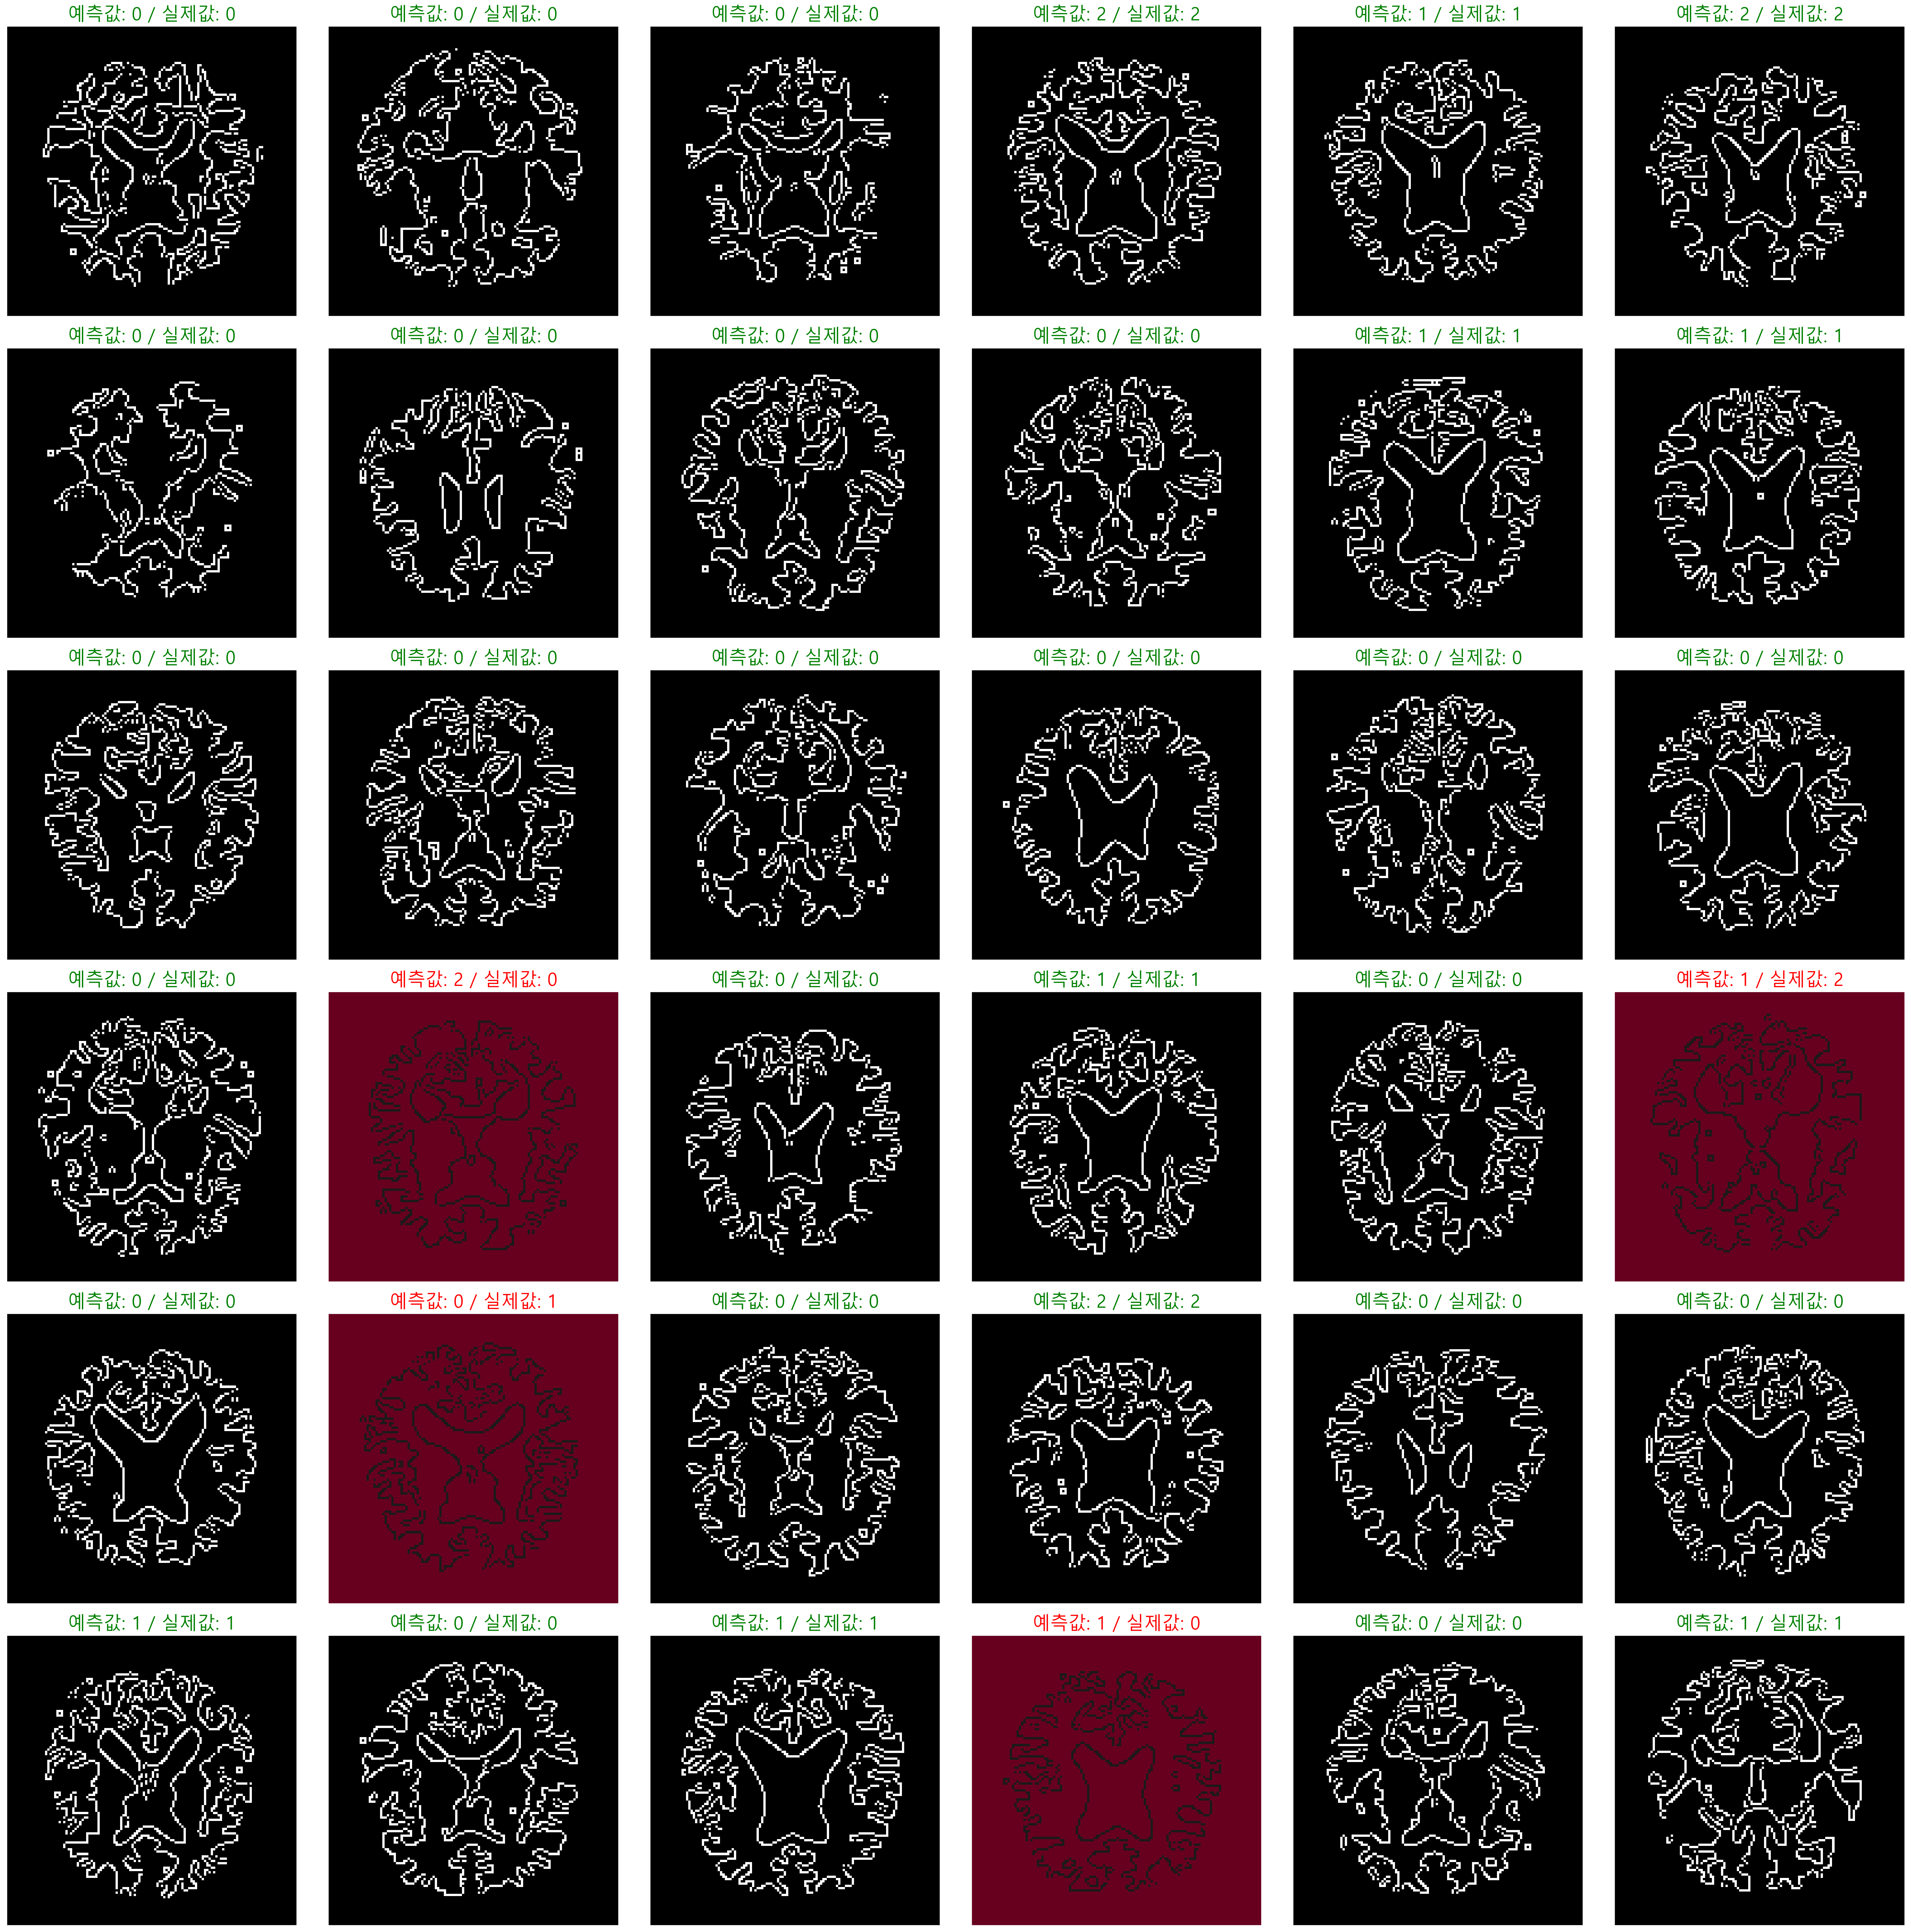

In [202]:
# 예측결과 예시
fig, ax = plt.subplots(6, 6, figsize=(30, 30))
w = (ax.shape)[0]
h = (ax.shape)[1]

for i in range(0, w*h):
    # 랜덤숫자 만들기
    rand = np.random.randint(0, len(X_test))
    
    # X_test, y_test에서 rand번째 값 가져오기
    y_pred = cnn.predict(X_test[rand].reshape(1, 128, 128, 1), verbose=0)
    y_pred_label = np.argmax(y_pred)
    y_test_label = np.argmax(y_test[rand])
    
    # actual, predicted, img 
    ax[i//w, i%w].set_title(f'예측값: {y_pred_label} / 실제값: {y_test_label}', fontsize=20, 
                            color='red' if y_test_label!=y_pred_label else 'green')
    ax[i//w, i%w].imshow(X_test[rand], 
                            cmap='gray' if y_test_label==y_pred_label else 'RdGy')
    ax[i//w, i%w].xaxis.set_visible(False)
    ax[i//w, i%w].yaxis.set_visible(False)

plt.tight_layout()

## 모델2

In [204]:
def build_model():
    input_img = Input(shape=X_train.shape[1:], name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(3, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [205]:
model =  build_model()

In [206]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 128, 128, 1)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 128, 128, 64)      640       
                                                                 
 Conv1_2 (Conv2D)            (None, 128, 128, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 64)        0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 64, 64, 128)       8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 64, 64, 128)       17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 32, 128)       0     

In [209]:
opt = Adam(learning_rate=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_weights.hdf5', save_best_only=True, save_weights_only=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [213]:
# Fit the model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2,
                    shuffle=True, callbacks=[es, chkpt],
                    class_weight = {0: 1.0, 1: 2.0, 2: 2.0}
)

Epoch 1/20
128/128 [==============================] - 229s 2s/step - loss: 1.5734 - accuracy: 0.3594 - val_loss: 1.0775 - val_accuracy: 0.3125
Epoch 2/20
128/128 [==============================] - 225s 2s/step - loss: 1.5701 - accuracy: 0.3601 - val_loss: 1.0868 - val_accuracy: 0.3125
Epoch 3/20
128/128 [==============================] - 228s 2s/step - loss: 1.5689 - accuracy: 0.3596 - val_loss: 1.0780 - val_accuracy: 0.3125
Epoch 4/20
128/128 [==============================] - 227s 2s/step - loss: 1.5697 - accuracy: 0.3591 - val_loss: 1.0786 - val_accuracy: 0.3125
Epoch 5/20
128/128 [==============================] - 224s 2s/step - loss: 1.5660 - accuracy: 0.3599 - val_loss: 1.0722 - val_accuracy: 0.3125
Epoch 6/20
128/128 [==============================] - 223s 2s/step - loss: 1.5342 - accuracy: 0.3750 - val_loss: 1.0889 - val_accuracy: 0.3125
Epoch 7/20
128/128 [==============================] - 226s 2s/step - loss: 1.4645 - accuracy: 0.4517 - val_loss: 0.9293 - val_accuracy: 0.5137

In [214]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.573372,0.359375,1.077542,0.312500
1,1.570074,0.360107,1.086849,0.312500
2,1.568909,0.359619,1.078048,0.312500
3,1.569728,0.359131,1.078580,0.312500
4,1.565961,0.359863,1.072231,0.312500
5,1.534215,0.375000,1.088904,0.312500
6,1.464534,0.451660,0.929299,0.513672
7,1.406695,0.496094,1.340608,0.214844
8,1.372441,0.515381,2.427555,0.166016
9,1.351307,0.522705,1.860179,0.166016


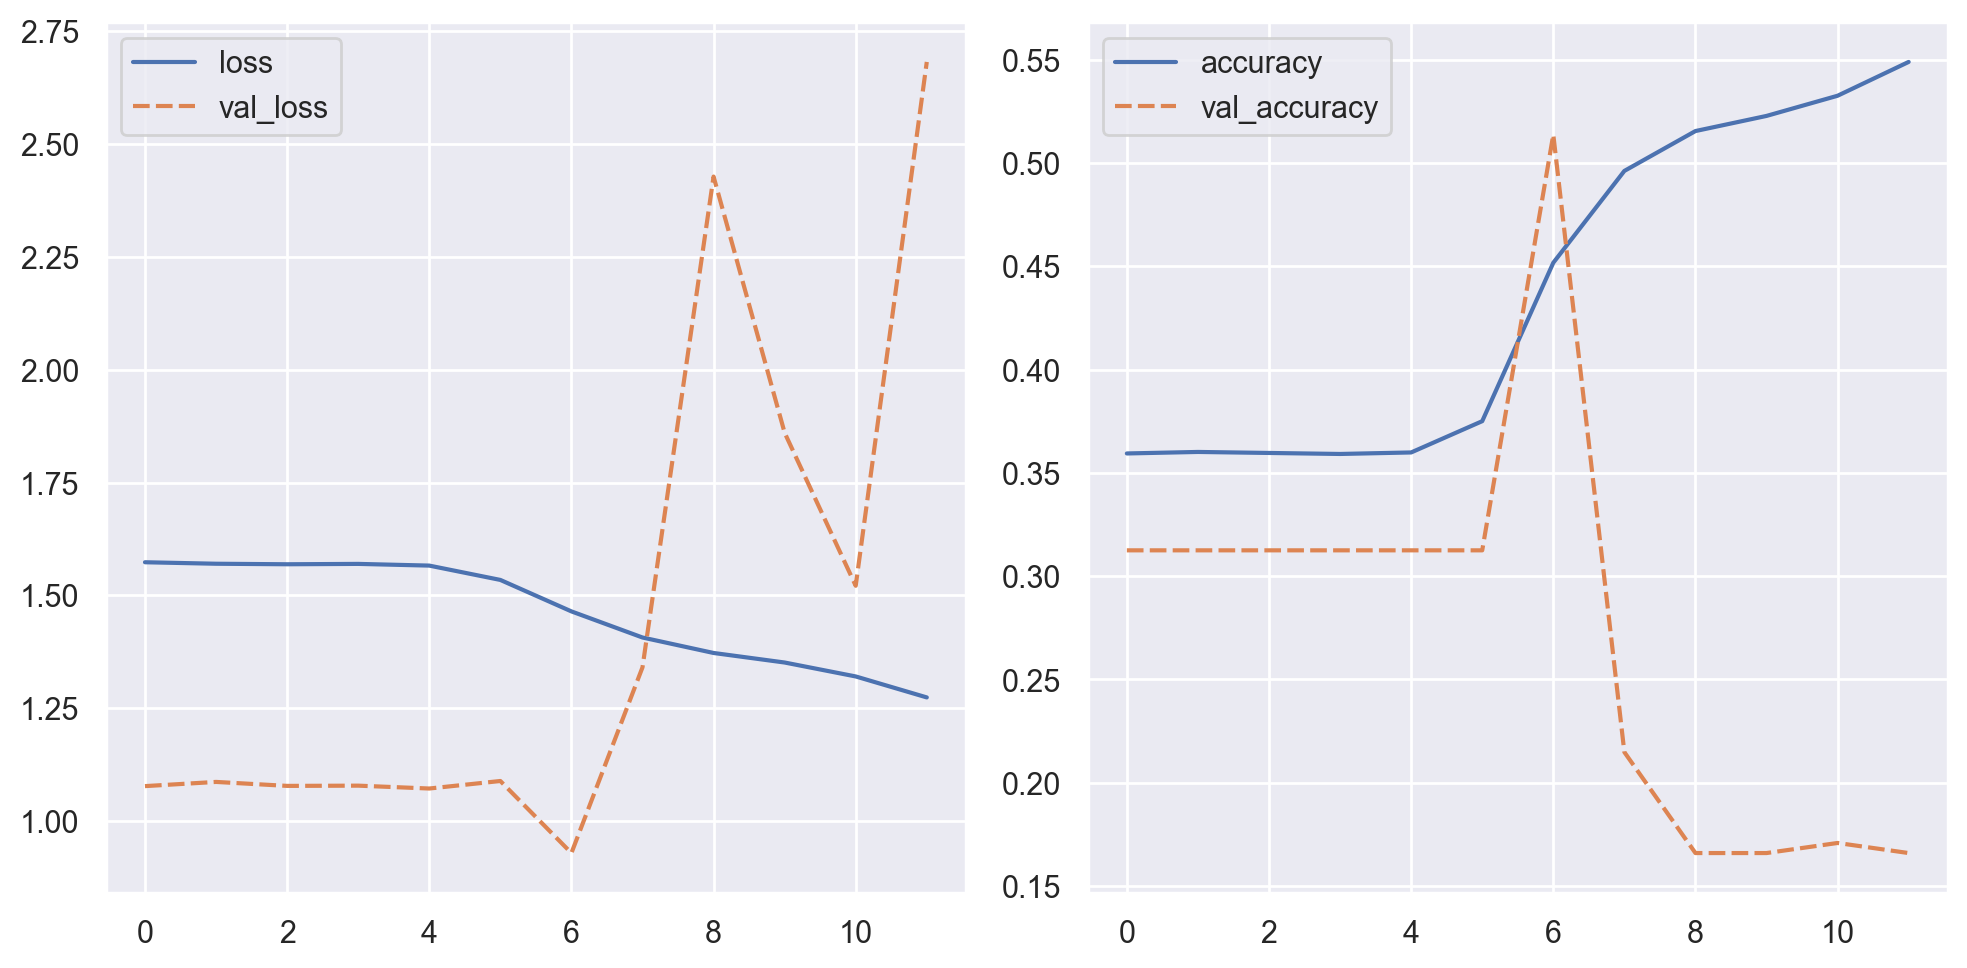

In [215]:
sns.set_theme()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=pd.DataFrame(history.history)[['loss', 'val_loss']], ax=ax[0])
sns.lineplot(data=pd.DataFrame(history.history)[['accuracy', 'val_accuracy']], ax=ax[1])

plt.tight_layout()

In [217]:
# Load the model weights
model.load_weights("best_model_weights.hdf5")

In [218]:
def result_summary(model, X_test, y_test):
    """
    model, X_test, y_test를 입력하면 confusion matrix, classification report를 보여주고
    y_pred_label을 리턴하는 함수
    """
    # X_test에 대한 정답값 예측
    y_pred = model.predict(X_test, verbose=0);
    
    # argmax로 클래스 중 정답값 선택
    y_test_label = [np.argmax(y) for y in y_test]
    y_pred_label = [np.argmax(y) for y in y_pred]

    # Classification Report
    clr = classification_report(y_test_label, y_pred_label)
    print("Classification Report\n----------------------\n", clr)

    # Confusion Matrix
    cm = confusion_matrix(y_test_label, y_pred_label)
    print("\n\nConfusion Matrix\n----------------------")
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual");

Classification Report
----------------------
               precision    recall  f1-score   support

           0       0.67      0.65      0.66       640
           1       0.41      0.61      0.49       448
           2       0.00      0.00      0.00       192

    accuracy                           0.54      1280
   macro avg       0.36      0.42      0.38      1280
weighted avg       0.48      0.54      0.50      1280



Confusion Matrix
----------------------


c:\Users\mook\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mook\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mook\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


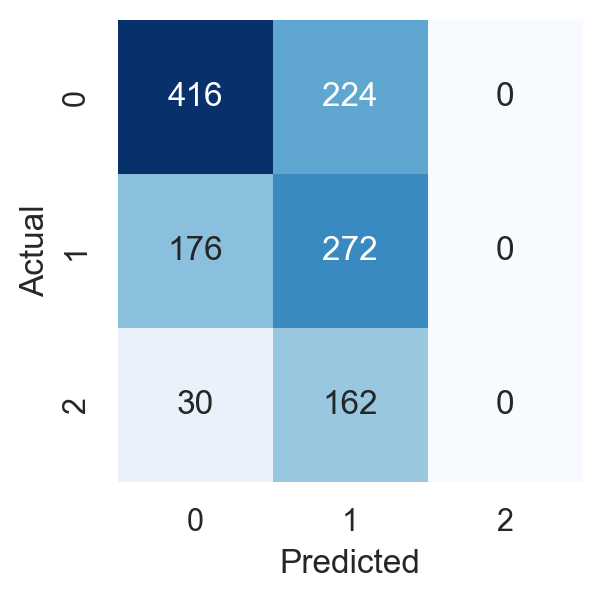

In [220]:
result_summary(model, X_test, y_test)

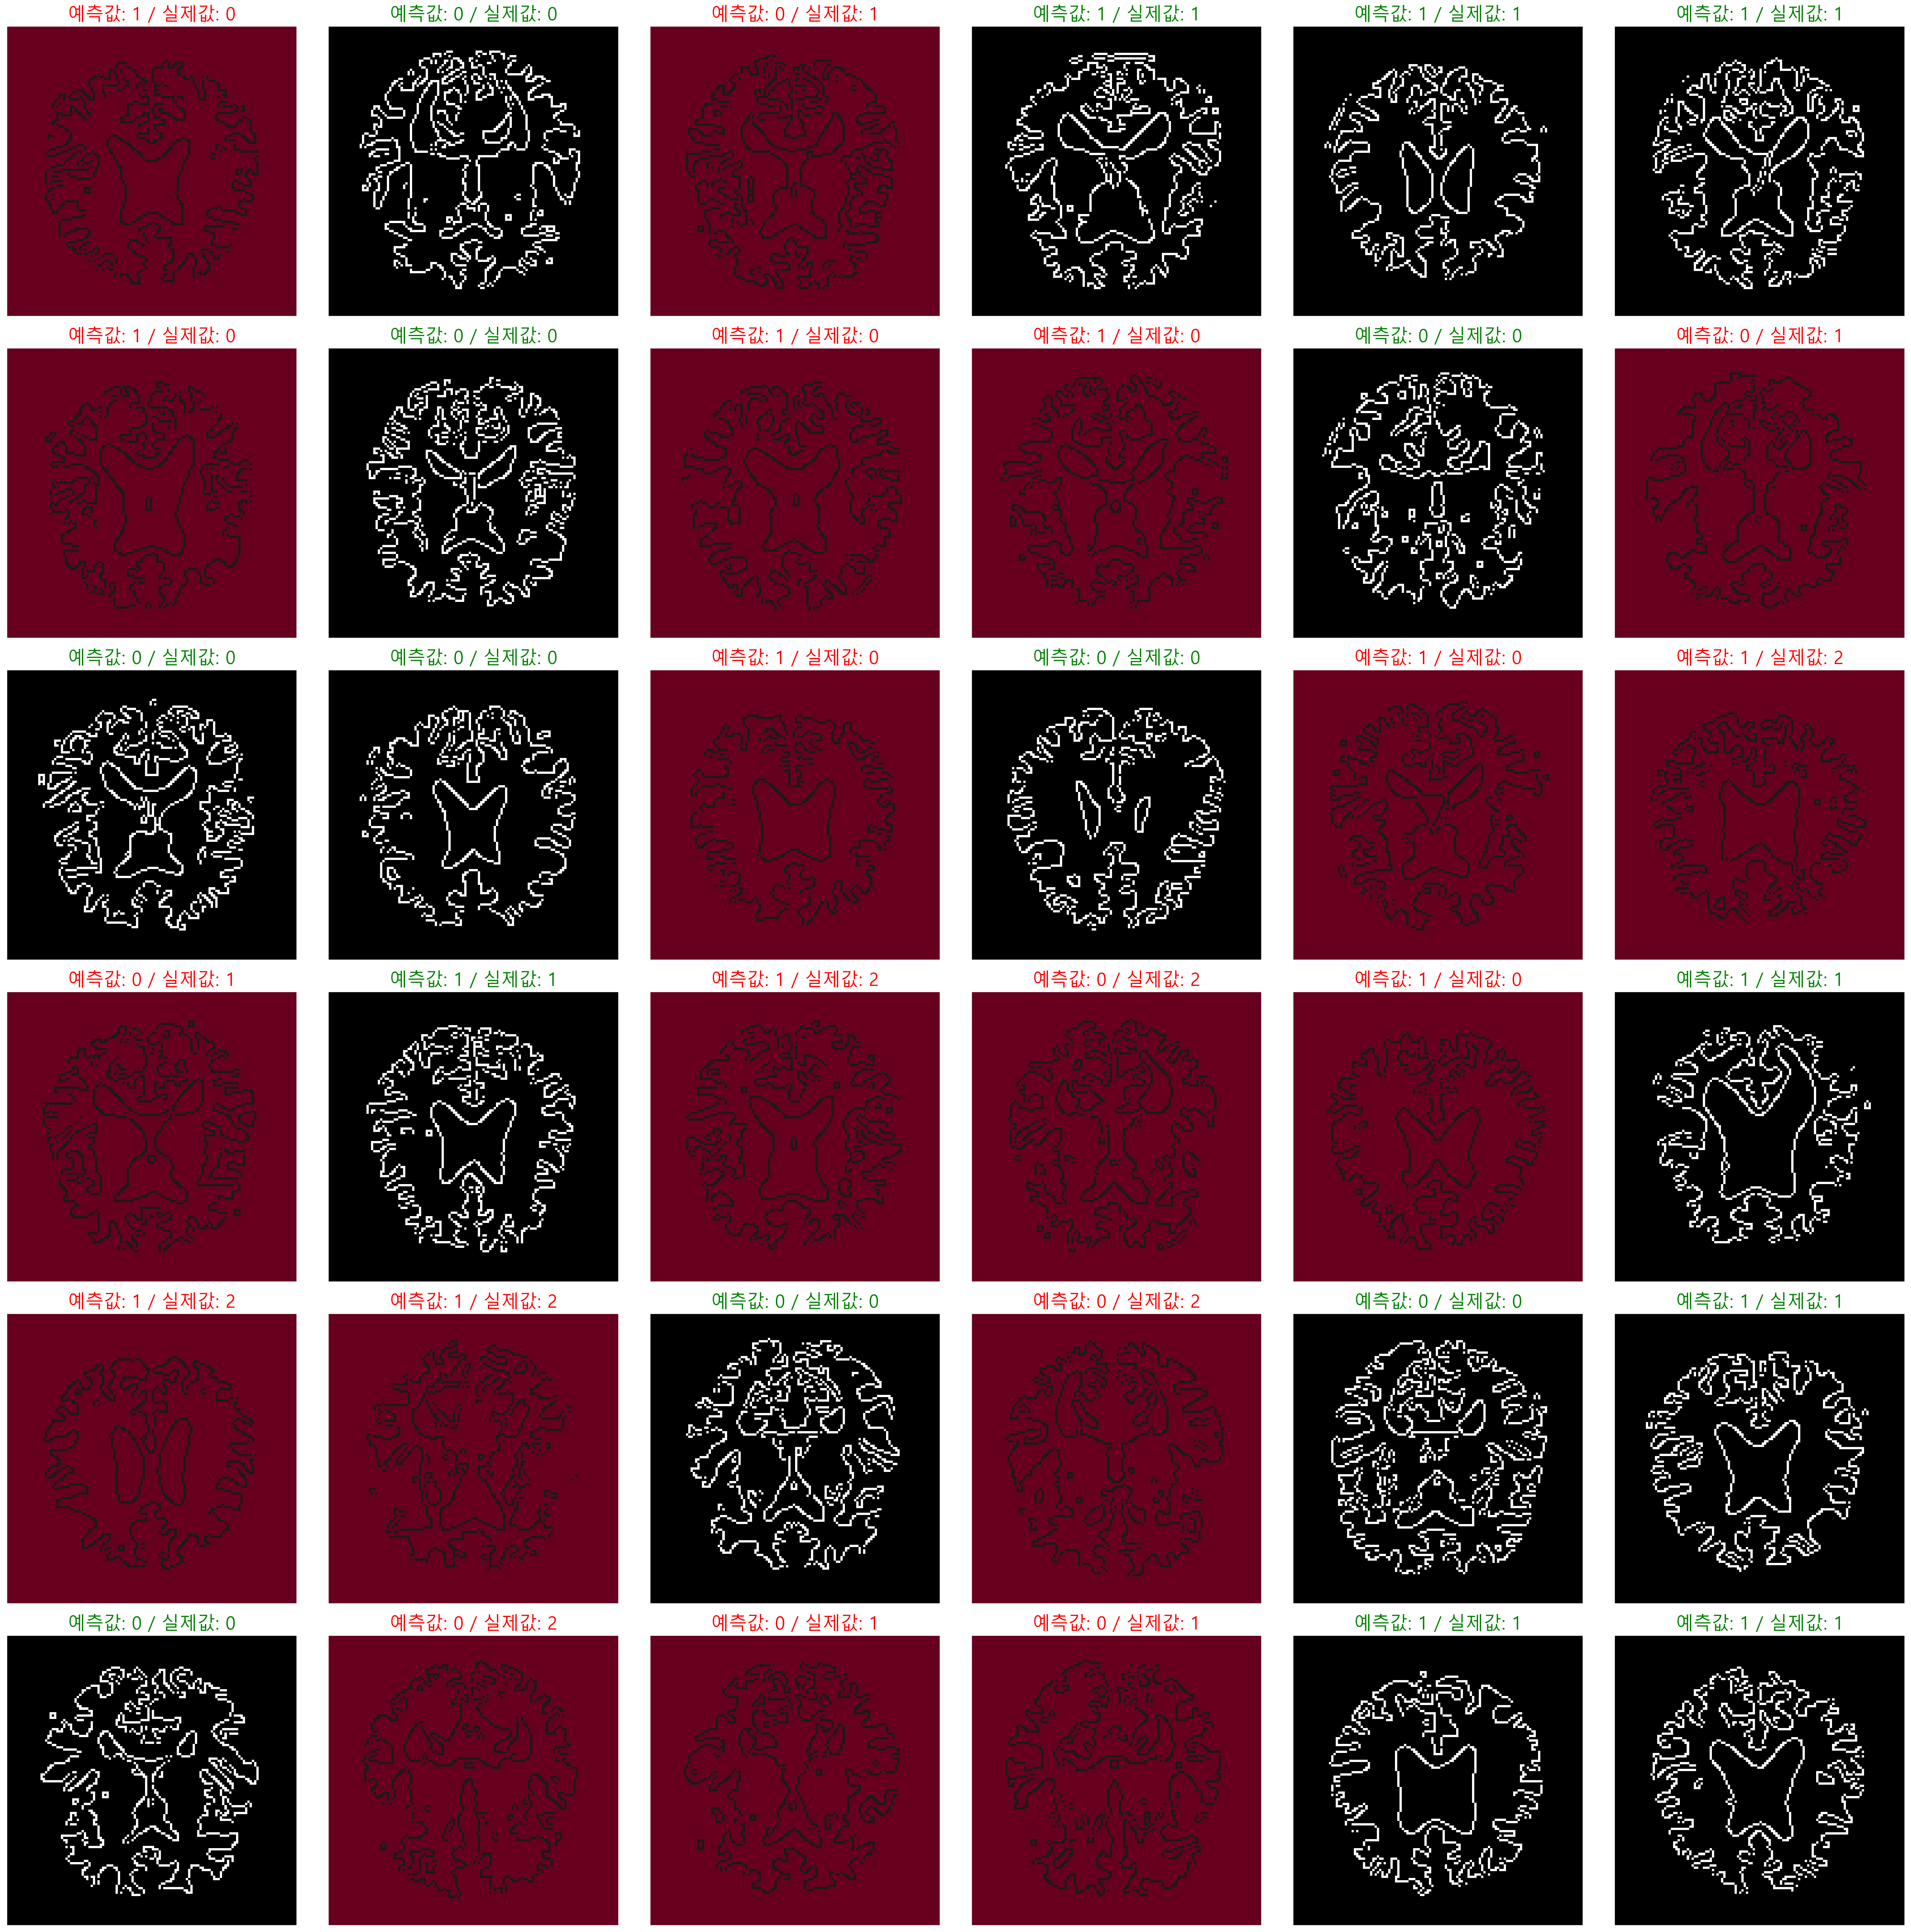

In [224]:
# 예측결과 예시
fig, ax = plt.subplots(6, 6, figsize=(30, 30))
w = (ax.shape)[0]
h = (ax.shape)[1]

for i in range(0, w*h):
    # 랜덤숫자 만들기
    rand = np.random.randint(0, len(X_test))
    
    # X_test, y_test에서 rand번째 값 가져오기
    y_pred = model.predict(X_test[rand].reshape(1, 128, 128, 1), verbose=0)
    y_pred_label = np.argmax(y_pred)
    y_test_label = np.argmax(y_test[rand])
    
    # actual, predicted, img 
    ax[i//w, i%w].set_title(f'예측값: {y_pred_label} / 실제값: {y_test_label}', fontsize=20, 
                            color='red' if y_test_label!=y_pred_label else 'green')
    ax[i//w, i%w].imshow(X_test[rand], 
                            cmap='gray' if y_test_label==y_pred_label else 'RdGy')
    ax[i//w, i%w].xaxis.set_visible(False)
    ax[i//w, i%w].yaxis.set_visible(False)

plt.tight_layout()